# **Análisis de Componentes Principales (II)**
## Las matemáticas detrás del PCA  

El PCA realizado en el anterior notebook "Análisis de Componentes Principales (I)" (insertar link) puede realizarse mediante la aplicación de su desarrollo algebraico. El procedimiento es menos directo pero puede ayudar a su comprensión.


In [ ]:
# Librerías para la preparación de datos
import pandas as pd
import numpy as np
import itertools

# Librerías para la Visualización 
import matplotlib.pyplot as plt

## Obtención y preparación de los datos  
En primer lugar descargamos el dataset de nuestra elección. En esta ocasión usaraemos uno creado a partir de datos provinciales proporcionados por el INE.


In [ ]:
file = r'/content/drive/MyDrive/Colab Notebooks/Python/provincias_temas_varios_2.xlsx'
datos = pd.read_excel(file, sheet_name='Datos').set_index('prov')
variables = pd.read_excel(file, sheet_name='Ficha').iloc[1:, :2]

# Eliminamos variables dicotómicas y nos quedamos con las numéricas
cols_dicot = datos.columns.str.contains('_')
datos = datos.loc[:, ~cols_dicot]

# Limpiamos todas las observaciones que contienen valores perdidos
datos = datos.apply(pd.to_numeric, axis=1, errors='coerce').dropna()

# Descripción de las variables
variables

,Variable,Descripción
1,neag,Número de explotaciones agrícolas (2009)
2,sagt,Superficie agrícola total (2009)
3,sagu,Superficie agrícola utilizada (2009)
4,benf,Beneficiarios de prestaciones por desempleo (2...
5,acem,Importe de todos los programas de Apoyo a la C...
6,acti,Personas en situación laboral activa (2019)
7,ocup,Personas en situación laboral de ocupación (2019)
8,para,Personas en situación laboral de desempleo (2019)
9,ejec,Ejecuciones hipotecarias de fincas urbanas de ...
10,inds,Número de empresas dentro del sector industria...


In [ ]:
# Visualizamos las primeras filas
datos.head(3)

,neag,sagt,sagu,benf,acem,acti,ocup,para,ejec,inds,cnst,ctrh,serv,pibc,ipib,inmi,pobl,espa
prov,,,,,,,,,,,,,,,,,,
Almería,22697.0,327346.0,234621.0,38299.166667,4383367.93,341.100,281.025,67.175,2026.0,2135.0,5703.0,18704.0,17550.0,19919.0,0.772923,8013.0,716820.0,570912.0
Cádiz,10069.0,540571.0,424849.0,75581.583333,5611899.98,563.325,423.125,154.950,454.0,2982.0,5916.0,27266.0,27210.0,18050.0,0.700400,6119.0,1240155.0,1194830.0
Córdoba,36641.0,1024515.0,844019.0,62022.833333,9458693.48,370.725,285.175,95.750,193.0,4196.0,5198.0,20196.0,18736.0,18525.0,0.718831,2966.0,782979.0,761876.0


El resultado es una matriz de datos de tamaño $n\times p$, con $p$ variables y $n$ observaciones.  
Si prescindimos de las librerías que contienen funciones para estandarizar los datos debemos recurrir a su implementación matemática. En primer lugar será necesario centrar los datos, es decir, restar a cada observación el valor medio de todas las observaciones, y tipificarlos 


In [ ]:
# Centramos los datos
datos_cent = datos.subtract(datos.mean())

# Alimentamos el estimador con los datos
datos_std = datos_cent / datos_cent.std(axis=0)

# Comprobamos que los datos están centrados y estandarizados
pd.DataFrame(datos_std, columns=datos.columns).describe().round(1).iloc[1:3, :]

,neag,sagt,sagu,benf,acem,acti,ocup,para,ejec,inds,cnst,ctrh,serv,pibc,ipib,inmi,pobl,espa
mean,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Construcción del análisis  
### La matriz de varianzas y covarianzas
El primer paso será la obtención de la matriz de varianzas y covarianzas de nuestro conjunto de datos. Esta matriz puede calcularse paso a paso de acuerdo a la siguiente expresión:
\begin{equation} 
\mathbf{S}={A}^\intercal{A} / n-1\\
\end{equation}
Siendo $A$ nuestra matriz de datos y $n$ el número de observaciones en nuestros datos.  


In [ ]:
# Hallamos la transpuesta de nuestra matriz de datos
datos_t = datos_std.transpose()
n = datos_std.shape[0]
cov_mat = datos_t.dot(datos_std).div((n - 1))

# visualizamos una muestras de las 4 primeras filas y columnas
pd.DataFrame(cov_mat, index=datos.columns, columns=datos.columns).iloc[:4, :4]

,neag,sagt,sagu,benf
neag,1.000000,0.383759,0.318163,0.217811
sagt,0.383759,1.000000,0.813661,-0.174668
sagu,0.318163,0.813661,1.000000,-0.105734
benf,0.217811,-0.174668,-0.105734,1.000000


Por suerte esta operación está incluída en la librería `numpy`

In [ ]:
# Matriz varianzas y covarianzas
S = datos_std.cov()

# comprobamos que por los dos métodos obtenemos la misma matriz de covarianzas
print('Las matrices S y cov_mat son iguales: ', np.allclose(S, cov_mat), '\n')

# Al usar datos estandarizados las matrices de covarianzas y correlaciones son idénticas
R = datos_std.corr()
print('Las matrices de covarianzas y correlaciones son iguales: ', 
      np.allclose(S, cov_mat))

Las matrices S y cov_mat son iguales:  True 

Las matrices de covarianzas y correlaciones son iguales:  True


__Autovalores y autovectores de la matriz de covarianzas__

A partir de estas matrices podemos calcular dos elementos clave en el Análisis de Componentes Principales: los vectores y los valores propios ç.

Los vectores propios de la matriz de covarianzas (o de correlaciones) se corresponden con los vectores directores de las componentes principales o factores obtenidos. Al mismo tiempo, los valores propios de estas matrices indican las varianzas explicadas por cada componente.  
A cada autovalor ${\lambda}_i$ de la matriz $\mathbf{S}$ le corresponde un autovector $\vec{v}_i$ tal que:

\begin{equation} 
\mathbf{S}\vec{v}_i={\lambda}_i\vec{v}_i\\
\end{equation}

Podemos obtenerlo sin necesidad de resolver el sistema de ecuaciones:

In [ ]:
vals_prop, vects_prop = np.linalg.eig(S)
print('valores propios: \n', vals_prop, '\n')
print('Dos primeros vectores propios: \n', vects_prop[:2], '\n')

  # Número total de componentes
n_comp = len(vects_prop)

valores propios: 
 [1.22467562e+01 2.80603260e+00 1.38598325e+00 7.34730315e-01
 3.30828447e-01 1.91604395e-01 1.47510807e-01 6.57862933e-02
 5.49016391e-02 1.66237426e-02 1.06212741e-02 4.03400983e-03
 2.45384716e-03 1.72404498e-03 3.22641090e-04 8.56576665e-05
 7.98127130e-07 8.39192463e-17] 

Dos primeros vectores propios: 
 [[ 1.09457760e-02 -4.38968828e-01 -3.00370298e-02 -6.92806615e-01
   5.54532529e-01  5.52745876e-02  9.50554858e-02 -3.96150364e-02
  -5.39167333e-02  5.02169255e-03  1.25595662e-02  2.86219452e-02
  -3.26416244e-02 -5.87298649e-03 -1.09939979e-02 -2.60153914e-03
  -1.81289408e-04 -1.56170152e-14]
 [-9.15702932e-02 -3.87749795e-01  5.21258301e-01  6.31783285e-02
  -8.85325583e-02 -5.72537152e-01 -4.36658441e-01 -1.71199368e-01
  -8.77393488e-02 -3.79276362e-02  8.84691021e-03  1.73896092e-02
  -1.54165689e-02 -1.17480715e-02  1.57164573e-03  7.14402231e-03
   2.78641243e-04  2.30804674e-14]] 



El elemento vectores propios contendrá un vector por cada variable original y cada vector estará compuesto por las coordenadas de cada una de las $n$ variables originales sobre los nuevos $n$ componentes.

In [ ]:
# comprobamos visualmente que se corresponden con los obtenidos en el notebook PCA(I)
componentes = pd.DataFrame(vects_prop.round(3), 
                           columns=['PC' + str(i) for i in range(1, datos_std.shape[1]+1)],
                           index=datos.columns).\
                           iloc[:3, :]
componentes


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
neag,0.011,-0.439,-0.030,-0.693,0.555,0.055,0.095,-0.040,-0.054,0.005,0.013,0.029,-0.033,-0.006,-0.011,-0.003,-0.0,-0.0
sagt,-0.092,-0.388,0.521,0.063,-0.089,-0.573,-0.437,-0.171,-0.088,-0.038,0.009,0.017,-0.015,-0.012,0.002,0.007,0.0,0.0
sagu,-0.064,-0.348,0.605,0.083,-0.244,0.560,0.349,0.014,0.071,0.028,0.001,-0.008,0.012,-0.015,-0.000,-0.004,-0.0,-0.0


Una de las propiedades de las componentes principales es que son ortonormales, por lo tanto:  
\begin{equation} 
\vec{v}_i\vec{v}_j=0;  \forall i \ne j
\end{equation}  



In [ ]:
# Necesitaremos los vectores propios en formato lista
u = [col for col in vects_prop.T.tolist()]

# Generamos todas las combinaciones posibles de productos i x j, i != j
indices = list(range(datos.shape[1]))
combos = itertools.combinations(indices, 2)

# vector que contiene todos los productos escalares entre vectores propios
ceros = [np.array(u[i]) @ np.array(u[j]) for i, j in combos]

#comprobación de que todos los productos son igual a 0
print('todos los productos escalares son cero:', 
      np.allclose(ceros, np.zeros(len(ceros))))

todos los productos escalares son cero: True


Además para cada vector $\vec{v}_i$ tenemos que $\sum_{j}{v}_{ij}^2=1$

In [ ]:
# Generamos un vector que contiene todas las sumas de cuadrados
unos = [sum(col**2) for col in vects_prop.T]

# Comprobamos que todos son igual a 11
print('todas las sumas de los cuadrados de componentes de los vectores propios son uno: ',
      np.allclose(unos, np.ones(len(unos))))

todas las sumas de los cuadrados de componentes de los vectores propios son uno:  True


Las puntuaciones o *scores* son las nuevas coordenadas de los datos originales expresadas en términos de las componentes principales. Serán por lo tanto una combinación lineal de éstos y puede expresarse en forma matricial como: 
\begin{equation} 
\mathbf{SCORES}={DATOS}*{COMPONENTES}\\
\end{equation}
Donde $DATOS$ es la matriz de nuestros datos originales estandarizados, de tamaño $n\times p$. $COMPONENTES$ será la matriz que contiene los vectores propios de la matriz de covarianzas.  

In [ ]:
# producto de matrices
scores = np.dot(datos_std, vects_prop)

# visualizamos una pequeña parte de la matriz producto como DataFrame
pd.DataFrame(scores, 
             columns=['PC' + str(i) for i in range(1, datos_std.shape[1]+1)],
             index=datos.index).\
             iloc[:3, :2]

,PC1,PC2
prov,,
Almería,-0.285668,-0.795002
Cádiz,0.282107,-1.232580
Córdoba,-0.656871,-2.580499


Como se ve más arriba mediante el producto de matrices se obtiene el mismo resultado que cuando utilizamos la función ```.transform()``` de la libreria ```sklearn```.  
También podemos obtener las varianzas explicadas ya que, como hemos dicho, se corresponde con los autovalores obtenidos de la matriz de covarianzas. Para obtener la misma representación que realizamos en el ejemplo anterior usando librerías, es necesario transformar las varianzas en la ratio de varianza. Ésto lo logramos dividiendo cada varianza por la suma de todas las varianzas.

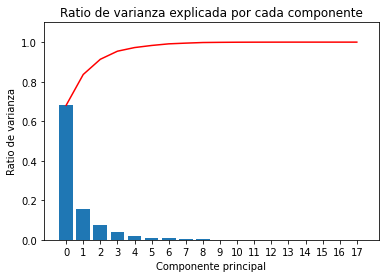

In [ ]:
# valores de la varianza de cada componente (o factor) extraida
varianzas = vals_prop

# varianza total explicada por todas las p componentes
total_varianza = np.sum(varianzas)

# ratio de varianza explicada por cada componente
varianzas_ratio = np.divide(varianzas, total_varianza)

# ratio acumulado
acumulado = varianzas_ratio.cumsum()

# Visualizamos las ratios de varianza explicados
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(componentes.shape[0]),
    height = varianzas_ratio
)
ax.plot(acumulado, c='red')
ax.set_xticks(np.arange(n_comp))
ax.set_ylim(0, 1.1)
ax.set_title('Ratio de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Ratio de varianza');
